## Clasificación con SVM y kNN del nivel de propagación epidémica de COVID-19

### Incidencia vs. sDist


### I. Importación de módulos.

In [1]:
import pandas as pd # para manipulación de datos. 
import numpy as np # álgebra lineal

#importamos paquetes de visualización de datos.
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
# generación de gráficos
%pylab inline 
pylab.rcParams['figure.figsize'] = (10, 6) #fijamos el tamaño predeterminado de las figuras

# para el preprocesamiento de datos con los que se
# correran ambos algoritmos
from sklearn.model_selection import train_test_split # partición de conjuntos
from sklearn.preprocessing import StandardScaler # escalamiento de variables

#para SVM
from sklearn.svm import SVC
#para kNN
from sklearn.neighbors import KNeighborsClassifier

#para optimización
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#para crear matrices de confusión
from sklearn.metrics import confusion_matrix



Populating the interactive namespace from numpy and matplotlib


### II. Carga del dataset, variables y clases. 


#### II.1 Dataset.
El dataset es el archivo ```LOG-complete-clasificacion.csv```, pero con la variable  `Escenario` renombrada numéricamente para los distintos Niveles de propagación (NvProp). 

In [2]:
data = pd.read_csv("LOG-complete-clasificacion-nvprop-num.csv")
print(data.shape)
data.head()


(280, 11)


,Incidencia,Virulencia,P-hosp,Letalidad,Acumulado hosp,sDist,N decesos infeccion,N decesos hosp,Acumulado defunciones,atpi,NvProp
0,0.345663,0.186916,0.079291,0.034177,5674,1976194036,763,414,1177,13979028,4
1,0.349166,0.183824,0.077651,0.033191,5539,1977327825,725,406,1131,13506194,4
2,0.345475,0.189153,0.080286,0.032014,5765,1987557951,687,405,1092,12880123,4
3,0.346643,0.182750,0.077771,0.032577,5639,1980234041,745,393,1138,13534679,4
4,0.343393,0.185834,0.080597,0.030944,5785,1986763877,677,399,1076,13112181,4


#### II.2 Clases

La variable respuesta es el Nivel de Propagación (```NvProp```) y, en este caso, las clases son numéricas, siendo:

* **1: NvProp Bajo**
* **2: NvProp Intermedio**
* **3: NvProp Alto**
* **4: NvProp Muy Alto**

In [8]:
print("Observaciones por Nivel de Propagación:\n", data['NvProp'].value_counts())

Observaciones por Nivel de Propagación:
 4    70
3    70
2    70
1    70
Name: NvProp, dtype: int64


In [112]:
y = data.loc[:, ['NvProp']]
print('\n' + 'Las clases en este dataset son\n\n' + str(np.unique(y)))
print('\n' + 'Niveles de propagación')


Las clases en este dataset son

[1 2 3 4]

Niveles de propagación


#### II.3 Variables

Por su parte, en X se encuentran las variables epidemiológicas que estarán involucradas en el algoritmo de 
clasificación. Para su fácil selección, la tabla a cotinuación muestra en qué índice se encuentra cada variable. 

| Variable      | Índice |
| --------------|--------|
| Incidencia    |   0    |
| Virulencia    |   1    |
| P-hosp        |   2    |
| Letalidad     |   3    |
| Acumulado hosp|   4    | |
| sDist         |   5    |
| N decesos inf |   6    |
| N decesos hosp|   7    |
| Acumulado def |   8    |
| atpi          |   9    |



In [113]:
#en este caso, tomaremos los índices correspondientes a las variables
# P-hosp, para el eje de las abscisas
# Virulencia en el eje de las ordenadas
# Establecer los valores de Ax y Ab para introducrilos cuando sea necesario obtener valores de X
Ax = 5
Ay = 0
X = data.iloc[:, [Ax, Ay]]
print(X.shape)
X.head()


(280, 2)


,sDist,Incidencia
0,1976194036,0.345663
1,1977327825,0.349166
2,1987557951,0.345475
3,1980234041,0.346643
4,1986763877,0.343393


In [61]:
# Generamos una función de visualización de datos
# con una gráfica de dispersión
def dispersion(X, y):
    # Guardamos los nombres para los ejes
    etiquetaX = X.columns[0]
    etiquetaY = X.columns[1]
    
    # Luego, Ambas variables, las convertiremos a objetos de tipo arreglo de numpy
    X = np.asarray(X)
    y = y['NvProp'].values.tolist()
    markers = ('o', '^', 'v', 'x')
    colors = ('lightblue', 'lightgreen', 'yellow', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], c=cmap(idx), marker=markers[idx], label=cl)
        plt.xlabel('{}'.format(etiquetaX))
        plt.ylabel('{}'.format(etiquetaY))
        plt.title('Gráfica de dispersión')
    plt.savefig('Clas_Disp_{0}-{1}.png'.format(etiquetaY, etiquetaX))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

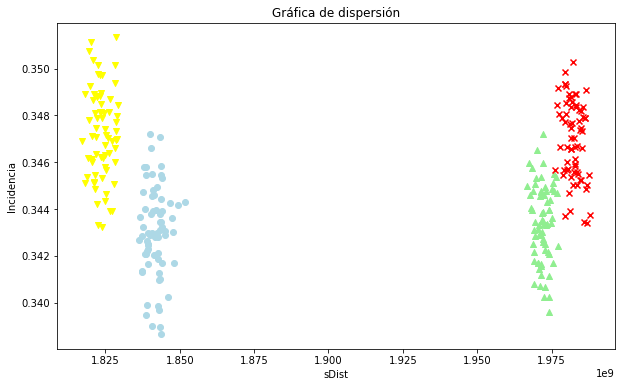

In [62]:
dispersion(X,y)

### III. Preparación de datos

In [63]:
# Para el algoritmo SVM
X_svm = X
# Para el algoritmo kNN
X_knn = X
print(X_svm.shape)

(280, 2)


#### III.1 Conjuntos de entrenamiento y prueba. 

El tamaño del conjunto prueba es $1/3$ del dataset.

In [66]:
# Para el algoritmo SVM
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, test_size=0.33, random_state=0)
# Para el algoritmo kNN
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.33, random_state=0)

In [67]:
# Imprimimos el contenido de cada dataset
#imprimimos el contenido de cada dataset
print('----SVM-----')
print('Hay {} muestras en el set de entrenamiento y {} muestras en el set de prueba'.format(
X_train_svm.shape[0], X_test_svm.shape[0]))
print('\n----kNN-----')
print('Hay {} muestras en el set de entrenamiento y {} muestras en el set de prueba'.format(
X_train_knn.shape[0], X_test_knn.shape[0]))

----SVM-----
Hay 187 muestras en el set de entrenamiento y 93 muestras en el set de prueba

----kNN-----
Hay 187 muestras en el set de entrenamiento y 93 muestras en el set de prueba


#### III.2 Escalamiento de características/variables (estandarización)

In [68]:
sc = StandardScaler()
sc_svm = sc.fit(X_train_svm)
sc_knn = sc.fit(X_train_knn)

'''Estandarización'''

X_train_svm_std = sc_svm.transform(X_train_svm)
X_test_svm_std = sc_svm.transform(X_test_svm)

X_train_knn_std = sc_knn.transform(X_train_knn)
X_test_knn_std = sc_knn.transform(X_test_knn)

# Muestra los datos estandarizados
print('Después de la estandarización de variables,\nel conjunto de entrenamiento se observa así:\n')
pd.DataFrame(X_train_svm_std, columns = X.columns).head()

Después de la estandarización de variables,
el conjunto de entrenamiento se observa así:



,sDist,Incidencia
0,-1.073047,0.813288
1,-1.183148,0.312721
2,1.030992,-0.057180
3,-1.177097,-0.015361
4,-0.941850,-0.442167


### IV. Ejecución de clasificadores. 

Ejecuión de clasificadores sin optimizar. 

#### IV.1. Clasificador SVM (sin optimizar).

In [83]:
#svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=1.0) # 'rbf' = radial basis function
##svm = SVC(kernel='linear', random_state=0, gamma=.1, C=1.0)
svm = SVC(kernel='poly', random_state=0, gamma=.1, C=100)
svm.fit(X_train_svm_std, y_train_svm)

print('La precisión del clasificador SVM con los datos de entrenamiento, es {:.2f} de 1'.format(svm.score(X_train_svm_std, y_train_svm)))
print('La precisión del clasificador SVM con los datos de prueba, es {:.2f} de 1'.format(svm.score(X_test_svm_std, y_test_svm)))

La precisión del clasificador SVM con los datos de entrenamiento, es 0.94 de 1
La precisión del clasificador SVM con los datos de prueba, es 0.95 de 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


####  IV.2. Visualización de las regiones de decisión. 

Creamos primero el algoritmo de visualización.

In [84]:
#import warnings 

def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Guardamos los nombres para los ejes
    print('Ingresa el nombre del eje X\n')
    etiquetaX = input()
    print('\nIngresa el nombre del eje Y\n')
    etiquetaY = input()
    print('\n¿Se ha optimizado el clasificador?\n SI = 1\n NO = 0')
    #esto solo es para  efectuar el etiquetado correcto del nombre de la imagen
    op = input()
    
    if str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '0':
        name = "kNN NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '0':
        name = "SVM NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '1':
        name = "kNN OPT"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '1':
        name = "SVM OPT"

    #ambas variables, las convertiremos a objetos de tipo arreglo de numpy
    X = np.asarray(X)
    y = y['NvProp'].values.tolist()
    
    # setup marker generator and color map
    #markers = ('s', 'x', 'o', '^', 'v')
    #colors = ('red', 'yellow', 'lightgreen', 'lightblue', 'cyan')
    markers = ('o', '^', 'v', 'x', 's')
    colors = ('lightblue', 'lightgreen', 'yellow', 'red', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel('{0} [estandarizada]'.format(etiquetaX))
    plt.ylabel('{0} [estandarizada]'.format(etiquetaY))
    plt.title('{0}\nRegión de decisión [estandarizada]'.format(name))

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    filelabel = "_{0}-{1}".format(etiquetaY, etiquetaX)
    plt.savefig("RES_{0}_{1}.png".format(name, filelabel))
    #print("----IMPORTANTE----\nRevise la carpeta destino de la figura guardada\npara modificar manualmente el nombre y evitar que se sobreescriba.")

Ingresa el nombre del eje X

sDist

Ingresa el nombre del eje Y

Incidencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

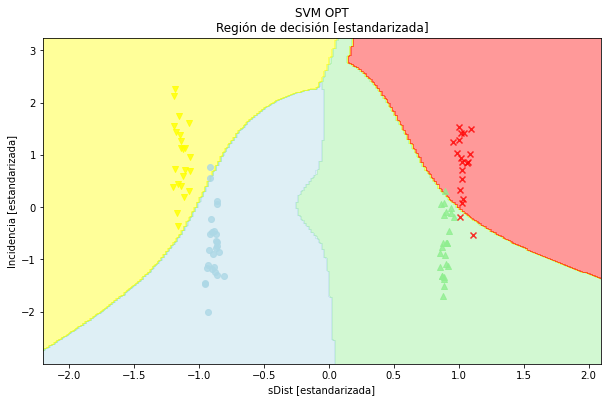

In [86]:
# graficamos las regiones de decisión para el clasificador SVM
# sin optimización
plot_decision_regions(X_test_svm_std, y_test_svm, svm)

#### IV.3. Clasificador kNN (sin optimizar).

In [98]:
knn = KNeighborsClassifier(n_neighbors=6, metric='minkowski')
knn.fit(X_train_knn_std, y_train_knn)

print('La precisión del clasificador kNN es {:.2f} de 1 en el set de entrenamiento'.format(knn.score(X_train_knn_std, y_train_knn)))
print('La precisión del clasificador kNN es {:.2f} de 1 en el set de prueba'.format(knn.score(X_test_knn_std, y_test_knn)))

La precisión del clasificador kNN es 0.95 de 1 en el set de entrenamiento
La precisión del clasificador kNN es 0.96 de 1 en el set de prueba


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Visualización de las regiones de decisión

Ingresa el nombre del eje X

sDist

Ingresa el nombre del eje Y

Incidencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

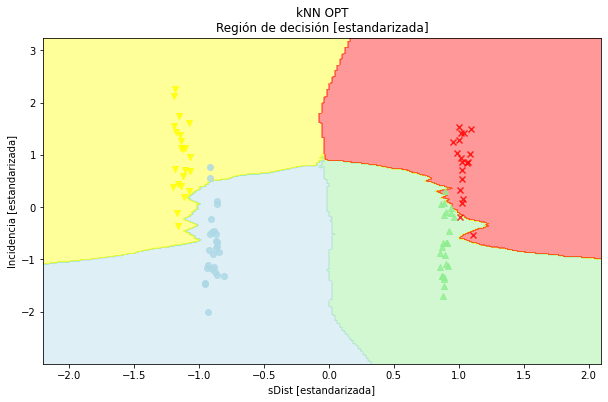

In [99]:
plot_decision_regions(X_test_knn_std, y_test_knn, knn)

#### IV.4. Matrices de confusión. 

In [100]:
def confusion(X_train_svm_std, y_train_svm, X_test_svm_std, y_test_svm, X_train_knn_std, y_train_knn, X_test_knn_std, y_test_knn, cl1, cl2):
    
    # Guardamos los nombres para los ejes
    print('Ingresa el nombre del eje X\n')
    etX = input()
    print('\nIngresa el nombre del eje Y\n')
    etY = input()
    print('\n¿Se ha optimizado el clasificador?\n SI = 1\n NO = 0')
    #esto solo es para  efectuar el etiquetado correcto del nombre de la imagen
    op = input()
    
    if op == '0':
        tipo_op = '\nAlgoritmos NO optimizados'
        t_op = 'NONOp'
    elif op == '1':
        tipo_op = '\nAlgoritmos Optimizados'
        t_op = 'Opt'
    
    filelbl = '{0}_{1}-{2}'.format(t_op, etY, etX)
    
    c_svm = cl1.fit(X_train_svm_std, y_train_svm)
    svm_cm=confusion_matrix(y_test_svm, c_svm.predict(X_test_svm_std))

    c_knn = cl2.fit(X_train_knn_std, y_train_knn)
    knn_cm=confusion_matrix(y_test_knn, c_knn.predict(X_test_svm_std))
    
    plt.figure(figsize=(15,6))
    plt.suptitle("Matrices de confusión {0}".format(tipo_op),fontsize=12)

    ax1 = plt.subplot(1,2,1)
    plt.title("SVM para {0} - {1}".format(etY, etX))
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.xaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']); ax1.yaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']);
    sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

    ax2 = plt.subplot(1,2,2)
    ax2.set_xlabel('Predicted labels');ax2.set_ylabel('True labels'); 
    ax2.xaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']); ax2.yaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']);
    plt.title("k-NN para {0} - {1}".format(etY, etX))
    sns.heatmap(knn_cm, annot = True, cmap="Blues",cbar=False);
    
    plt.savefig('RES_ConfMatrix-{0}.png'.format(filelbl))

Ingresa el nombre del eje X

sDist

Ingresa el nombre del eje Y

Incidencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


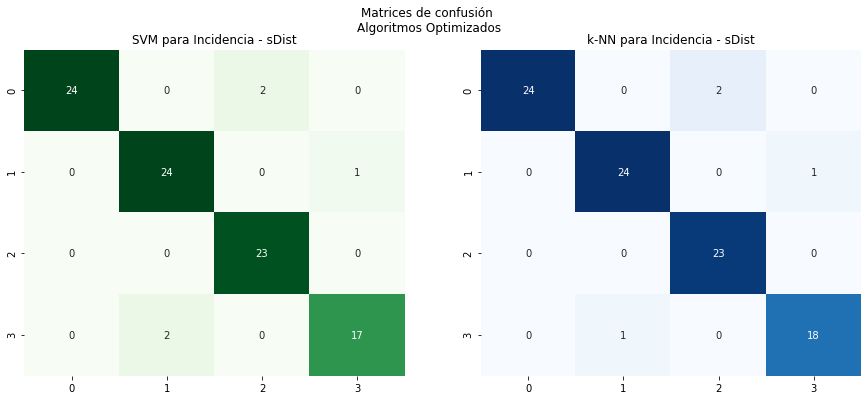

In [101]:
# generamos la matriz de confusión.
confusion(X_train_svm_std, y_train_svm, X_test_svm_std, y_test_svm, X_train_knn_std, y_train_knn, X_test_knn_std, y_test_knn, svm, knn)

Regiones de decisión

#### V.2. Clasificador kNN (Optimizado).

Una forma de optimizar, es a partir de encontrar únicamente el número de vecinos k que determine la mejor precisión del clasificador,

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

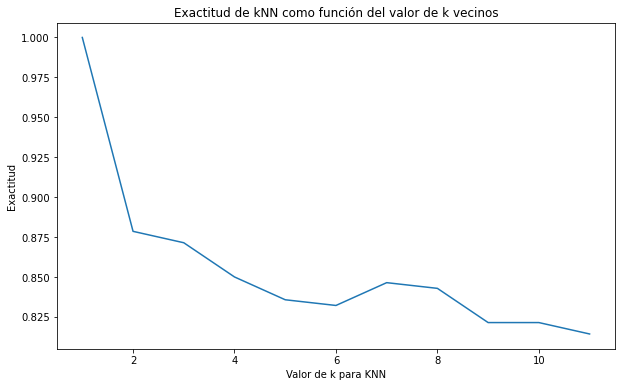

In [79]:
# determinar cuál es el mejor valor de n

k_range = list(range(1,12)) #creamos una lista con 26 valores posibles para k
scores = [] #una variable vacía para almacenar 

for k in k_range:
    #knn = KNeighborsClassifier(n_neighbors=k)
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn.fit(X, y)
    y_pred = knn.predict(X)
    #scores.append(metrics.accuracy_score(y, y_pred))
    scores.append(metrics.accuracy_score(y, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Valor de k para KNN')
plt.ylabel('Exactitud')
plt.title('Exactitud de kNN como función del valor de k vecinos')
plt.show()

### VI. Predicción. 

El dataset es el archivo de ```LOG-X.csv``` 

In [107]:
data_v = pd.read_csv("LOG-X-clasificacion.csv")
print(data_v.shape)
data_v.head()


(54, 11)


,Incidencia,Virulencia,P-hosp,Letalidad,Acumulado hosp,sDist,N decesos infección,N decesos hosp,Acumulado defunciones,atpi,NvProp
0,0.339748,0.193426,0.078240,0.034210,4096,1840276193,529,289,818,44821120,X
1,0.343153,0.190718,0.077038,0.034611,4228,1839781439,588,286,874,45500559,X
2,0.343396,0.188678,0.076523,0.032796,4151,1841055679,532,282,814,45439954,X
3,0.341585,0.188153,0.075349,0.033471,3924,1846273222,545,250,795,43598534,X
4,0.344792,0.188248,0.076420,0.032690,4034,1843685285,544,251,795,43864192,X


Seleccionamos las variables con las que efectuaremos la predicción. 

In [108]:
Pred = data_v.iloc[:, [Ax, Ay]]
#X_pred.to_csv("X_pred.csv")
print(Pred.shape)
Pred.head()

(54, 2)


,sDist,Incidencia
0,1840276193,0.339748
1,1839781439,0.343153
2,1841055679,0.343396
3,1846273222,0.341585
4,1843685285,0.344792


Determinemos las estadísticas de los parámetros de interés. 

In [53]:
# para las variables crudas
a = Pred.describe()
a

,sDist,Incidencia
count,5.400000e+01,54.000000
mean,1.841842e+09,0.343084
std,3.180396e+06,0.001710
min,1.833720e+09,0.339483
25%,1.840122e+09,0.341566
50%,1.841312e+09,0.343298
75%,1.843888e+09,0.344407
max,1.850257e+09,0.346022


In [54]:
P = a.iloc[[5], :]
P

,sDist,Incidencia
50%,1.841312e+09,0.343298


c) **Con la mediana (cuartil 50%) como *medida resumen* datos crudos**

In [55]:
X_pred_res = pd.DataFrame(columns=["sDist", "P-hosp"], data=[[1.841312e+09, 0.343298]])
X_pred_res

,sDist,P-hosp
0,1.841312e+09,0.343298


In [103]:
# usando KNN
knn.predict(X_pred_res)

array([4], dtype=int64)

In [102]:
# usando svm
svm.predict(X_pred_res)

array([4], dtype=int64)

d) **Con la mediana (cuartil 50%) como *medida resumen* datos escalados**

In [109]:
stc = StandardScaler()
sc_pred = stc.fit(Pred)

'''Estandarización'''

X_pred_std = sc_pred.transform(Pred)


# Muestra los datos estandarizados
print('Después de la estandarización de variables,\nel conjunto de validación/predicción observa así:\n')
X_std = pd.DataFrame(X_pred_std, columns = X.columns)
s = X_std.describe()
Ps = s.iloc[[5], :]
Ps

Después de la estandarización de variables,
el conjunto de validación/predicción observa así:



,sDist,Incidencia
50%,-0.167969,0.125776


**Grafica del valor predicho** 

In [110]:
# usando svm
svm.predict(Ps)

array([2], dtype=int64)

In [111]:
knn.predict(Ps)

array([1], dtype=int64)